In [1]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from sympy import real_roots
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.optimize import fsolve
import scipy
import matplotlib as mpl
import palettable
import statistics
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
catch22_feature_names = ["DN_HistogramMode_5", "DN_HistogramMode_10", "CO_f1ecac", "CO_FirstMin_ac", "CO_HistogramAMI_even_2_5", "CO_trev_1_num", 
                            "MD_hrv_classic_pnn40", "SB_BinaryStats_mean_longstretch1", "SB_TransitionMatrix_3ac_sumdiagcov", 
                            "PD_PeriodicityWang_th0_01", "CO_Embed2_Dist_tau_d_expfit_meandiff", 
                            "IN_AutoMutualInfoStats_40_gaussian_fmmi", "FC_LocalSimple_mean1_tauresrat", 
                            "DN_OutlierInclude_p_001_mdrmd", "DN_OutlierInclude_n_001_mdrmd", "SP_Summaries_welch_rect_area_5_1", 
                            "SB_BinaryStats_diff_longstretch0", "SB_MotifThree_quantile_hh", "SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1", 
                            "SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1", "SP_Summaries_welch_rect_centroid", "FC_LocalSimple_mean3_stderr"]

In [3]:
def gen_hopf(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
    ic = np.array(np.random.uniform(size=2))
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:, 0]

In [236]:
def sample_hopf(num_samples, eta_val=None, n_val=None, mu_val=None, seed=0):
    np.random.seed(seed=seed)
    regime_store = list()
    # hopf system
    if eta_val is not None:
        eta_val_hopf = np.repeat(eta_val, num_samples)
    else:
        eta_val_hopf = np.random.uniform(0.01, 1, num_samples)
    if mu_val is not None:
        mu_val_hopf = np.repeat(mu_val, num_samples)
    else:
        mu_val_hopf = np.random.uniform(-5, 5, num_samples)
    if n_val is not None:
        N_val_hopf = np.repeat(n_val, num_samples)
    else:
        N_val_hopf = np.random.uniform(50, 5000, num_samples)
    lengths_store = list()
    sols_list = list()
    for i in range(num_samples):
        # check regime
        if mu_val_hopf[i] > 0:
            regime_store.append('LimitCycle')
        else:
            regime_store.append('FixedPoint')
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        N = N_val_hopf[i]
        sol = gen_hopf(eta, mu, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)

    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    ts = sols_list # return list of 2 dim. time series
    df = pd.DataFrame(features_hopf, columns=catch22_feature_names)
    df['N'] = lengths_store
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['system'] = 'Hopf'
    df['regime'] = regime_store

    return ts, df

In [5]:
def gen_bistable(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
    ic = np.array([np.random.uniform()])
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:] # exclude 500 samples for transients

In [237]:
def sample_bistable(num_samples, eta_val=None, n_val=None, mu_val=None, seed=643):
        np.random.seed(seed=seed)
        # bistable system
        regime_store = list()
        if eta_val is not None:
            eta_val_bistable = np.repeat(eta_val, num_samples)
        else:
            eta_val_bistable = np.random.uniform(0., 1, num_samples)
        if mu_val is not None:
            mu_val_bistable = np.repeat(mu_val, num_samples)
        else:
            mu_val_bistable = np.random.uniform(-5, 5, num_samples)
        if n_val is not None:
            N_val_bistable = np.repeat(n_val, num_samples)
        else:
            N_val_bistable = np.random.uniform(50, 5000, num_samples)
        lengths_store = list()
        sols_list = list()
        for i in range(num_samples):
            mu = mu_val_bistable[i]
            eta = eta_val_bistable[i]
            N = N_val_bistable[i]
            sol = gen_bistable(eta, mu, N)
            lengths_store.append(len(sol)) # store length of time series after burn in
            sols_list.append(sol)
            X = smp.Symbol('x', real=True)
            eq = mu + X - X**3
            roots = [j.n(6) for j in real_roots(eq, X)]
            max_root = np.max(roots)
            min_root = np.min(roots)
            max_actual = np.max(sol)
            min_actual = np.min(sol)
            # check for switching
            if (max_actual >= max_root) & (min_actual <= min_root) & (len(roots) > 1):
                regime_store.append('Switching')
            else:
                regime_store.append('FixedPoint')
    
        features_bistable = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
        ts = sols_list # return list of 2 dim. time series
        df = pd.DataFrame(features_bistable, columns=catch22_feature_names)
        df['N'] = lengths_store
        df['mu'] = mu_val_bistable
        df['eta'] = eta_val_bistable
        df['system'] = 'Bistable'
        df['regime'] = regime_store
    
        return ts, df


In [7]:
def gen_hookes(mu, eta, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x = state
            dxdt = -mu*x
            return dxdt
    ic = np.array(np.random.uniform(low=0, high=0.01, size=1))
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:]

In [238]:
def sample_fixedpt(num_samples, eta_val=None, n_val=None, mu_val=None, seed=42):
    np.random.seed(seed=seed)
    # fixed point system
    if eta_val is not None:
        eta_val_fixedpt = np.repeat(eta_val, num_samples)
    else:
        eta_val_fixedpt = np.random.uniform(0.01, 1, num_samples)
    if n_val is not None:
        N_val_fixedpt = np.repeat(n_val, num_samples)
    else:
        N_val_fixedpt = np.random.uniform(50, 5000, num_samples)
    if mu_val is not None:
        mu_val_fixedpt = np.repeat(mu_val, num_samples)
    else:
        mu_val_fixedpt = np.random.uniform(0.01, 5, num_samples)
    lengths_store = list()
    sols_list = list()
    for i in range(num_samples):
        mu = mu_val_fixedpt[i]
        eta = eta_val_fixedpt[i]
        N = N_val_fixedpt[i]
        sol = gen_hookes(mu, eta, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)

    features_fixedpt = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    ts = sols_list # return list of 2 dim. time series
    df = pd.DataFrame(features_fixedpt, columns=catch22_feature_names)
    df['N'] = lengths_store
    df['eta'] = eta_val_fixedpt
    df['system'] = 'Hookes'
    df['regime'] = 'FixedPoint'

    return ts, df

In [265]:
ts1, df1 = sample_hopf(num_samples=500, eta_val = 0.01, n_val=5000, mu_val=-5)
ts2, df2 = sample_bistable(num_samples=500, eta_val = 0.01, n_val=5000, mu_val=0)
ts3, df3 = sample_fixedpt(num_samples=500, eta_val = 0.01, n_val=5000, mu_val=5)

In [266]:
x = pd.concat([df1, df2, df3], ignore_index=True)
ts = ts1 + ts2 + ts3

In [15]:
# load in saved data
#x = pd.read_csv('naive_df_lowNoise.csv')
#ts = np.load('naive_ts_lowNoise.pickle', allow_pickle=True)

In [267]:
rs = RobustScaler().fit(x.iloc[:,:22])
rs_transformed = rs.transform(x.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed

In [268]:
pca = PCA(n_components=2).fit(xhat)
embedding = pca.transform(xhat)

In [269]:
x['PC1'] = embedding[:,0]
x['PC2'] = embedding[:,1]

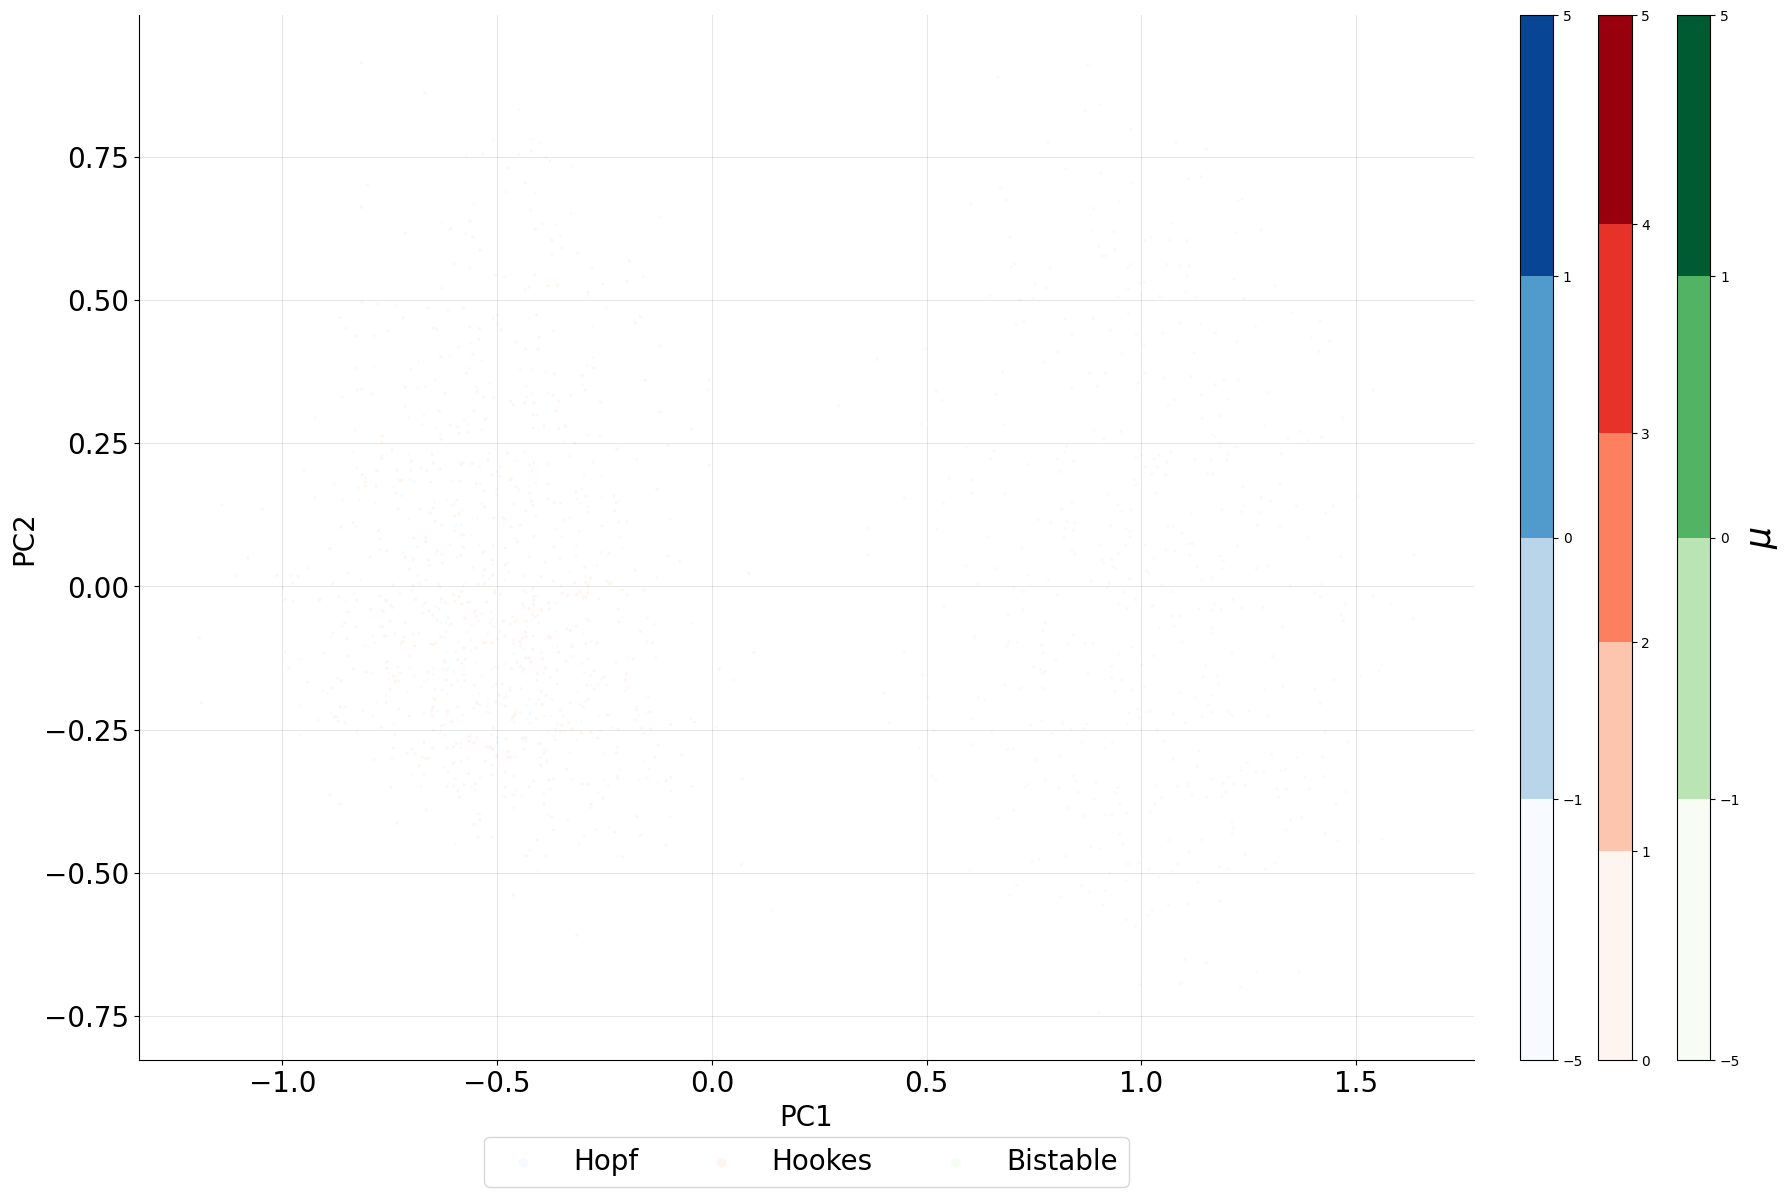

In [270]:
fig, (ax, cax1, cax2, cax3) = plt.subplots(ncols=4, figsize=(18,12),
                        gridspec_kw={"width_ratios":[1,0.025,0.025,0.025]})

                        
cmap_hopf = palettable.colorbrewer.sequential.Blues_8.mpl_colormap
bounds_hopf = [-5, -1, 0, 1, 5]
norm = mpl.colors.BoundaryNorm(bounds_hopf, cmap_hopf.N)

# separate data into 3 regimes
x_hopf = x[x['system'] == 'Hopf']
x_bistable = x[x['system'] == 'Bistable']
x_fixedpt = x[x['system'] == 'Hookes']

# plot Hopf
pa = ax.scatter(x_hopf['PC1'], x_hopf['PC2'], c=x_hopf['mu'], cmap=cmap_hopf,  label='Hopf', s=1.5)
cba = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_hopf), cax=cax1)

# plot hookes
cmap_hookes = palettable.colorbrewer.sequential.Reds_8.mpl_colormap
bounds_hookes = [0, 1, 2, 3, 4, 5]
norm = mpl.colors.BoundaryNorm(bounds_hookes, cmap_hookes.N)
pb = ax.scatter(x_fixedpt['PC1'], x_fixedpt['PC2'], c=x_bistable['mu'], cmap=cmap_hookes, label='Hookes', s=1.5)
cbb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_hookes), cax=cax2)

# plot bistable
cmap_bistable = palettable.colorbrewer.sequential.Greens_8.mpl_colormap
bounds_bistable = [-5, -1, 0, 1, 5]
norm = mpl.colors.BoundaryNorm(bounds_bistable, cmap_bistable.N)
pc = ax.scatter(x_bistable['PC1'], x_bistable['PC2'], c=x_bistable['mu'], cmap=cmap_bistable, label='Bistable', s=1.5)
cbc = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_bistable), cax=cax3).set_label(r'$\mu$', fontsize=25)

# setup plot
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.grid(color='k', linestyle='-', linewidth=0.7, alpha = 0.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=3, fancybox=True, shadow=False, fontsize=20, markerscale=5, )




ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
fig.tight_layout()


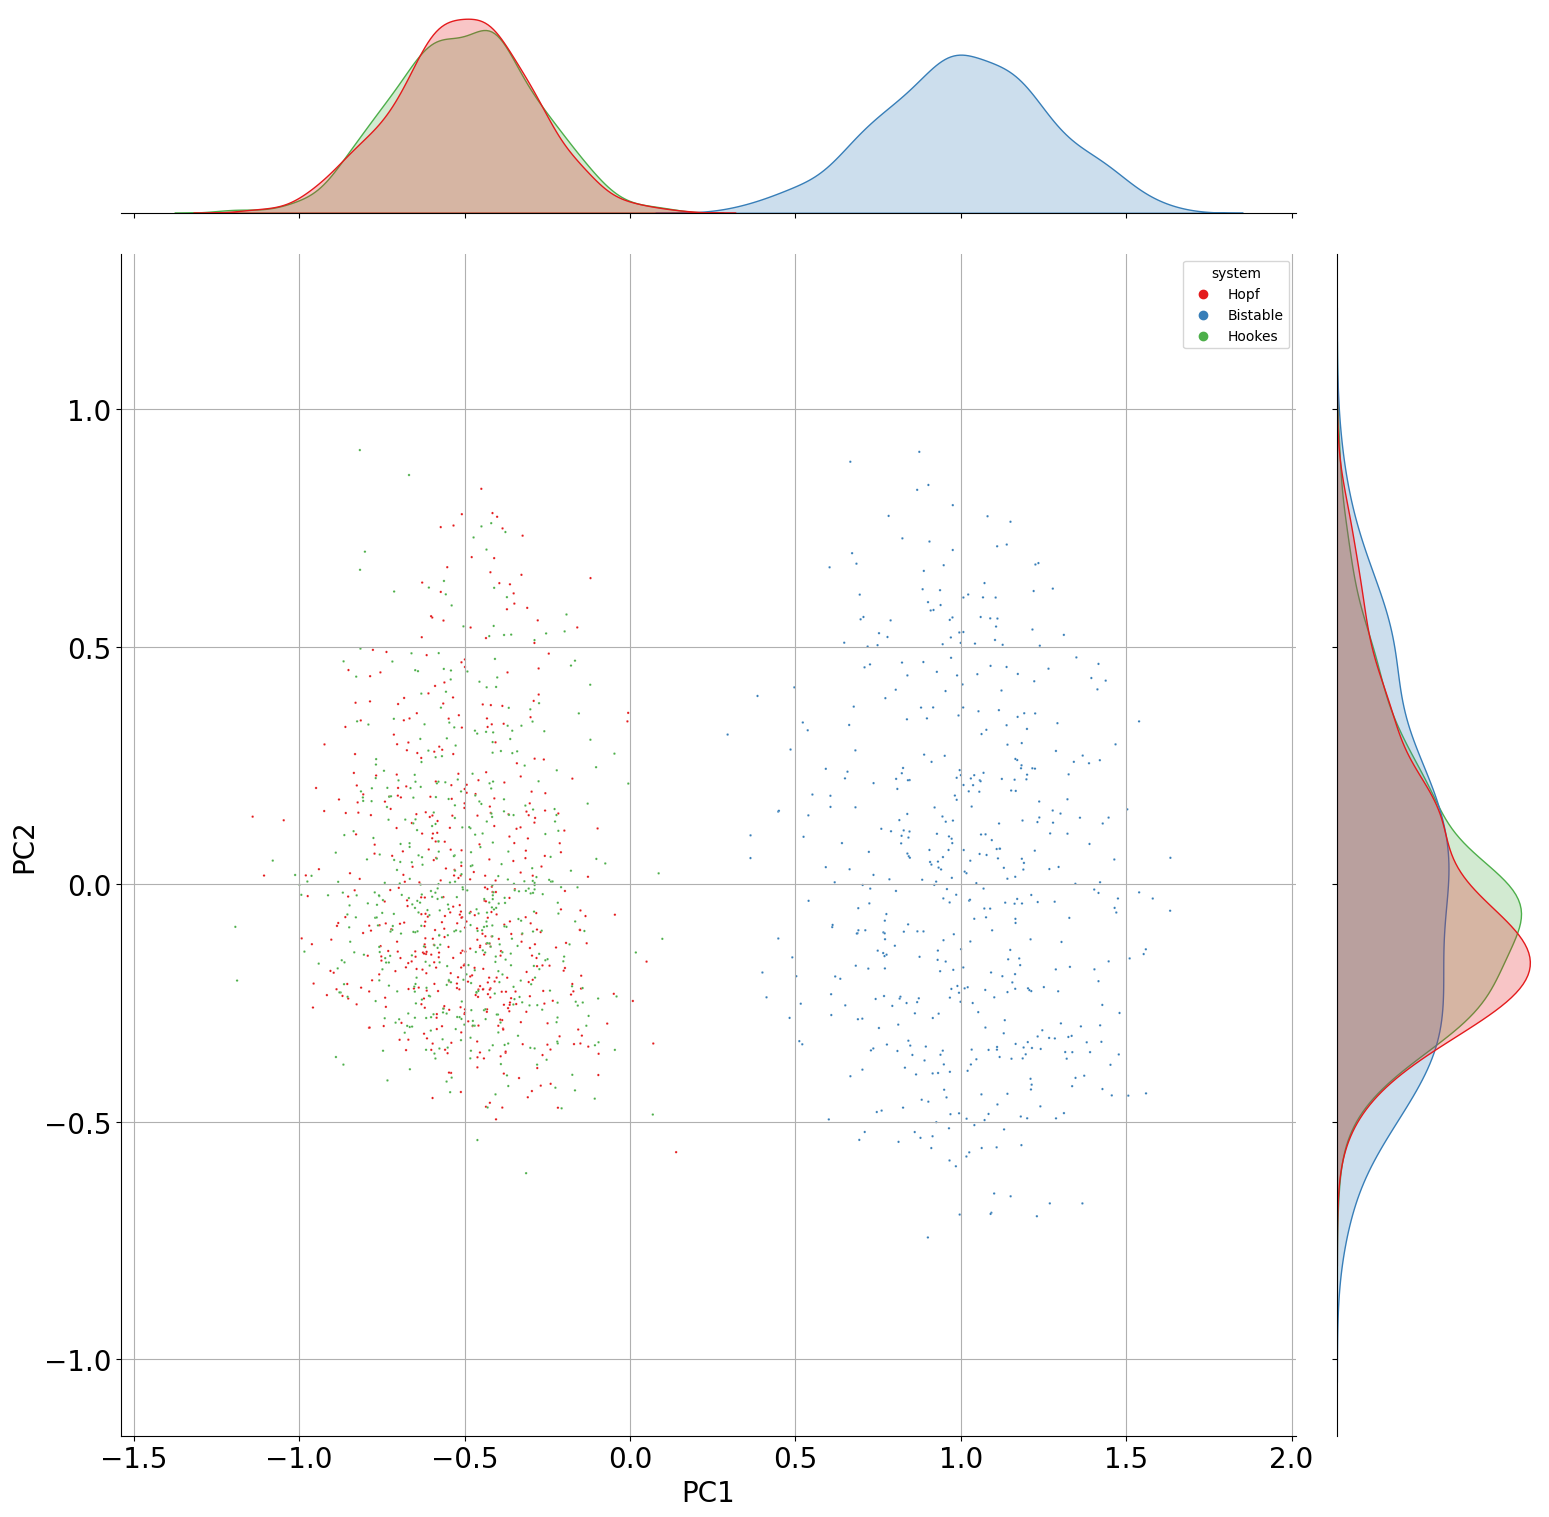

In [271]:
# add marginal distributions
joint_plot = sns.jointplot(data=x, x='PC1', y='PC2', hue='system', palette='Set1', s=3, height=15)
joint_plot.ax_joint.set_xlabel('PC1', fontsize=20)
joint_plot.ax_joint.set_ylabel('PC2', fontsize=20)
joint_plot.ax_joint.tick_params(axis='x', labelsize=20)
joint_plot.ax_joint.tick_params(axis='y', labelsize=20)
plt.grid()

## Case study

Let's simulate a new data point from a hopf system in the fixed point regime and see how the naive method performs.

simulating from any arbitrary potential, using Newton's second law and Euler-Maruyama to simulate the dynamics with noise:
$$F = ma$$
$$F = m \ddot{x} = -\nabla U$$ 
$$\dot{v} = -\nabla U \quad \dot{x} = v$$


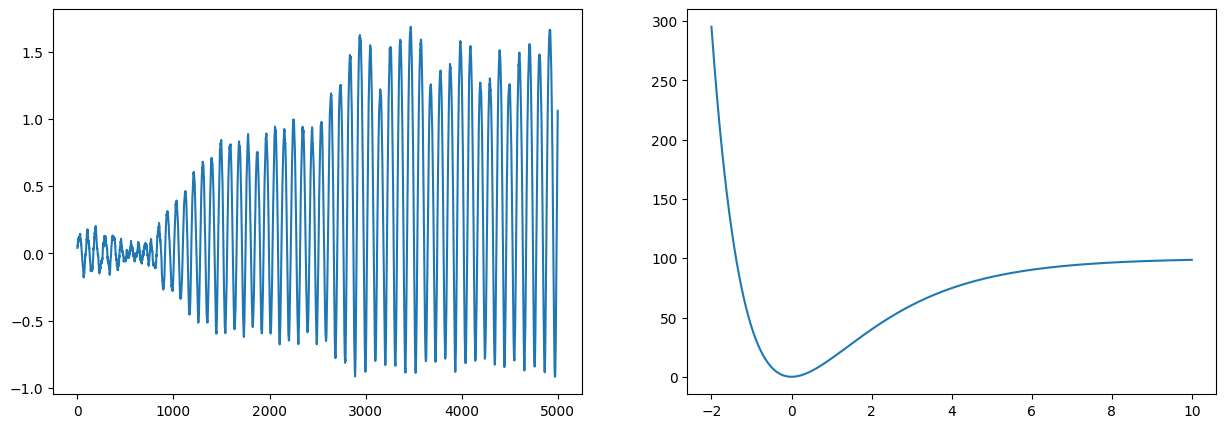

In [235]:

# Define the potential function
def potential(x, a, b):
    return a*(1-np.exp(-b*x))**2

# Define the system of ODEs
# Reduce second order ODE to two first order ODEs for Newton's second law
def f(state, t):
    x, v = state[0], state[1]
    dxdt = v
    dvdt = -(2*a*b*(1-np.exp(-b*x))*np.exp(-b*x)) # - grad(V)
    return dxdt, dvdt

# Set the constants for the potential function
a = 100
b = 0.5


# use sdeint as usual
dt = 0.01
eta = 0.1
N = 5000
length = ((N+500)*dt)
tspan = np.arange(0, length, dt)

ic = np.array(np.random.uniform(low=0, high=0.01, size=2))
gw = lambda y, t: eta * np.identity(ic.shape[0])
fw = lambda y, t: np.array(f(y,t))
sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
fig, ax = plt.subplots(1, 2,figsize=(15,5))
ax[0].plot(sol[500:,0])
ax[1].plot(np.linspace(-2, 10, 1000), potential(np.linspace(-2, 10,1000), a, b))

